In [2]:
import json
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import japanize_matplotlib
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from beir.datasets.data_loader import GenericDataLoader
from pyserini.analysis import Analyzer, get_lucene_analyzer
from tqdm import tqdm_notebook

/home/iida.h/work/IR/SPLADE_VOCAB/.venv_20230727/lib/python3.8/site-packages/beir/datasets/data_loader.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
analyzer = Analyzer(get_lucene_analyzer())

In [4]:
plt.rcParams['font.family'] = 'IPAexGothic'
# fp = FontProperties(fname='/home/iida.h/download/times-new-roman.ttf')
matplotlib.matplotlib_fname()

'/home/iida.h/.config/matplotlib/matplotlibrc'

In [5]:
def calc_idf(corpus):
    N = len(corpus)
    idf = defaultdict(float)
    df = Counter()
    for cid, doc in tqdm_notebook(corpus.items()):
        text = doc["title"] + " " + doc["text"]
        t_doc = analyzer.analyze(text)
        df.update(list(set(t_doc)))
    
    for v, freq in df.items():
        idf[v] = np.log(N/freq)
    return df, idf

In [6]:
def calc_rsj(index_corpus, queries, qrels, N):
    rsj = {}
    for qid, q_qrels in qrels.items():
        try:
            query = queries[qid]
        except KeyError:
            continue
        t_query = analyzer.analyze(query)
        rel_q_qrels = {k: v for k, v in q_qrels.items() if v > 0}
        Nr = len([i for i in q_qrels.values() if i > 0])
        if Nr < 1:
            continue
        wtq = defaultdict(float)
        for t in t_query:
            Dt = index_corpus[t]
            Nt = len(Dt)
            Ntr = 0
            for did in Dt:
                if did in rel_q_qrels:
                    Ntr+= 1
                   
            pt = Ntr / Nr
            not_pt = (Nt - Ntr) / (N - Nr)
            wtq[t] = np.log(((Ntr + 0.5)*(N - Nt - Nr + Ntr + 0.5))/((Nr - Ntr + 0.5)*(Nt - Ntr + 0.5)) )
            # print(qid, t, N, Nt, Nr, Ntr, wtq[t], ((Ntr + 0.5)*(N - Nt - Nr + Ntr + 0.5)), (Nr - Ntr + 0.5)*(Nt - Ntr + 0.5))
        rsj[qid] = wtq
    return rsj

In [7]:
data_path = "/home/gaia_data/iida.h/BEIR/datasets/msmarco"
ms_corpus, ms_queries, ms_qrels = GenericDataLoader(data_folder=data_path).load(split="test")

KeyboardInterrupt: 

In [7]:
ms_df, ms_idf = calc_idf(ms_corpus)
ms_N = len(ms_corpus)

/tmp/ipykernel_11415/4271899555.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for cid, doc in tqdm_notebook(corpus.items()):


  0%|          | 0/8841823 [00:00<?, ?it/s]

In [8]:
def df_diff_rsj(name_and_path, rsj_u, bin_rsj_u, index_corpus, queries, N, bin_names):
    rsj_info_bin = []
    for name, path in name_and_path.items():
        # if "BM25併用" in name:
        #     all_rels = path
        # else:
        with open(path) as f:
            all_rels = json.load(f)
        
        if name != "BM25":
            all_rels = list(all_rels.values())[0]
        topK_rels = {}
        for qid, rels in all_rels.items():
            topK_rels[qid] = dict(sorted(rels.items(), key=lambda x: -x[1])[:100])

        rsj_s = calc_rsj(index_corpus, queries, topK_rels, N)

        for bin_name in bin_names:
            for qid in rsj_u:
                t_query = analyzer.analyze(queries[qid])
                for t in t_query:
                    try:
                        if bin_rsj_u[qid][t] == bin_name:
                            diff_rsj = rsj_s[qid][t] - rsj_u[qid][t]
                            rsj_info_bin.append((name, bin_name, diff_rsj))
                    except:
                        continue
                    
    df_rsj_info_bin = pd.DataFrame(rsj_info_bin, columns=["retriever", "bin", "ΔRSJ"])
    return df_rsj_info_bin
            

In [9]:
# mean_df = np.mean(list(df.values()))
median_idf = np.median([v for t, v in idf.items() if t in all_query_term] )
# q75, q25 = np.percentile(list(idf.values()), [75 ,25])

rsj_u = calc_rsj(index_corpus, queries, qrels, N)
mq75, mq25 = np.percentile([v for qid, term_value in rsj_u.items() for t, v in term_value.items()], [75, 25])
print(median_idf, mq75)

bin_rsj_u = {}
for t in idf:
    for qid, rsj_uq in rsj_u.items():
        if qid not in bin_rsj_u:
            bin_rsj_u[qid] = {}
        if t not in rsj_uq:
            bin_rsj_u[qid][t] = "OOV"
            continue
        if idf[t] < median_idf:
#             bin_rsj_u[qid][t] = "LowIDF"
            if rsj_uq[t] > mq75:
                bin_rsj_u[qid][t] = "HighRSJ:LowIDF"
            else:
                bin_rsj_u[qid][t] = "LowRSJ:LowIDF"
        else:
#             bin_rsj_u[qid][t] = "HighIDF"
            if rsj_uq[t] > mq75:
                bin_rsj_u[qid][t] = "HighRSJ:HighIDF"
            else:
                bin_rsj_u[qid][t] = "LowRSJ:HighIDF"


NameError: name 'idf' is not defined

In [10]:
dataset = "nfcorpus"
vocab = "71694"
data_path = f"/home/gaia_data/iida.h/BEIR/datasets/{dataset}"
corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")

  0%|          | 0/3633 [00:00<?, ?it/s]

In [11]:
df, idf = calc_idf(corpus)
N = len(corpus)

all_query_term = set()
for query in queries.values():
    t_query = analyzer.analyze(query)
    all_query_term |= set(t_query)


index_corpus = defaultdict(list)
for cid, doc in corpus.items():
    text = doc["title"] + " " + doc["text"]
    t_doc = analyzer.analyze(text)
    for t in set(t_doc):
        index_corpus[t].append(cid)
        
max_idf = int(np.ceil(np.max(list(idf.values()))))
min_idf = int(np.floor(np.min(list(idf.values()))))
# bin_idf = {}
# for t in df:
#     if (df[t] / N) > (ms_df.get(t, 0) / ms_N) * 5:
#         if idf[t] > 5:
#             bin_idf[t] = "IDF+:Over5"
#         else:
#             bin_idf[t] = "IDF+:Under5"
#     else:
#         if idf[t] > 5:
#             bin_idf[t] = "IDF-:Over5"
#         else:
#             bin_idf[t] = "IDF-:Under5"

/tmp/ipykernel_2901649/4271899555.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for cid, doc in tqdm_notebook(corpus.items()):


  0%|          | 0/3633 [00:00<?, ?it/s]

In [12]:
# mean_df = np.mean(list(df.values()))
idf = {t: np.log(N/v) for t, v in df.items()}
median_idf = np.median([v for t, v in idf.items() if t in all_query_term] )
q75, q25 = np.percentile(list(idf.values()), [75 ,25])

rsj_u = calc_rsj(index_corpus, queries, qrels, N)
mq75, mq25 = np.percentile([v for qid, term_value in rsj_u.items() for t, v in term_value.items()], [75, 25])
print(median_idf, mq75)

bin_rsj_u = {}
for t in idf:
    for qid, rsj_uq in rsj_u.items():
        if qid not in bin_rsj_u:
            bin_rsj_u[qid] = {}
        if t not in rsj_uq:
            bin_rsj_u[qid][t] = "OOV"
            continue
        if idf[t] < median_idf:
#             bin_rsj_u[qid][t] = "LowIDF"
            if rsj_uq[t] > mq75:
                bin_rsj_u[qid][t] = "HighRSJ:LowIDF"
            else:
                bin_rsj_u[qid][t] = "LowRSJ:LowIDF"
        else:
#             bin_rsj_u[qid][t] = "HighIDF"
            if rsj_uq[t] > mq75:
                bin_rsj_u[qid][t] = "HighRSJ:HighIDF"
            else:
                bin_rsj_u[qid][t] = "LowRSJ:HighIDF"

4.560227872494816 4.094654548604004


In [13]:
idf = {t: np.log(N/v) for t, v in df.items()}
median_idf = np.median([v for t, v in idf.items() if t in all_query_term] )
q75, q25 = np.percentile(list(idf.values()), [75 ,25])

rsj_u = calc_rsj(index_corpus, queries, qrels, N)
mq75, mq25 = np.percentile([v for qid, term_value in rsj_u.items() for t, v in term_value.items()], [75, 25])
print(median_idf, q75, mq75)

bin_rsj_u_idf = {}
for t in idf:
    for qid, rsj_uq in rsj_u.items():
        if qid not in bin_rsj_u_idf:
            bin_rsj_u_idf[qid] = {}
        if t not in rsj_uq:
            bin_rsj_u_idf[qid][t] = "OOV"
            continue
        if idf[t] < q75:
            bin_rsj_u_idf[qid][t] = "LowIDF"
        else:
            bin_rsj_u_idf[qid][t] = "HighIDF"

4.560227872494816 8.197814032221203 4.094654548604004


In [14]:
def top_ranked_count(index_corpus, queries, qrels, N):
    count = {}
    for qid, q_qrels in qrels.items():
        try:
            query = queries[qid]
        except KeyError:
            continue
        t_query = analyzer.analyze(query)
        rel_q_qrels = {k: v for k, v in q_qrels.items() if v > 0}
        t_count = defaultdict(float)
        for t in t_query:
            Dt = index_corpus[t]
            Nt = len(Dt)
            Ntr = 0
            for did in Dt:
                if did in rel_q_qrels:
                    Ntr+= 1
                    
            t_count[t] = Ntr
                   
        count[qid] = t_count
    return count
    

In [15]:
def df_top_ranked_count(name_and_path, bin_rsj_u, index_corpus, queries, N, bin_names):
    count_info_bin = []
    for name, path in name_and_path.items():
        with open(path) as f:
            all_rels = json.load(f)
        
        if name != "BM25":
            all_rels = list(all_rels.values())[0]
        topK_rels = {}
        for qid, rels in all_rels.items():
            topK_rels[qid] = dict(sorted(rels.items(), key=lambda x: -x[1])[:100])
            
        count_s = top_ranked_count(index_corpus, queries, topK_rels, N)

        for bin_name in bin_names:
            for qid in count_s:
                t_query = analyzer.analyze(queries[qid])
                for t in t_query:
                    try:
                        if bin_rsj_u[qid][t] == bin_name:
                            count_info_bin.append((name, bin_name, count_s[qid][t]))
                    except:
                        continue
                    
    df_count_info_bin = pd.DataFrame(count_info_bin, columns=["retriever", "bin", "count"])
    return df_count_info_bin
            
    
            
        

In [16]:
splade_name_and_path = {
    "No-DA": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/splade-org/analysis.json",
    "AdaLM": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/mlm-splade-org/{vocab}/analysis.json",
    "AdaLM-IDF": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/mlm-splade-idf/{vocab}/analysis.json",
    "AdaLM-GPL": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/mlm-splade-gpl-self-org/{vocab}/analysis.json",
    "AdaLM-IDF-BoW": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/mlm-splade-tk-idf/{vocab}/analysis.json",
}

splade_name_and_path = {
    "BM25": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/bm25/analysis.json",
    "SPLADE": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/splade-org/analysis.json",
    "SPLADE+GPL": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/splade-gpl-self-org/analysis.json",
    "SPLADE+AdaLM": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/mlm-splade-org/{vocab}/analysis.json",
    "SPLADE+AdaLM+BM25併用": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/mlm-splade-idf/{vocab}/analysis.json",
    
    "AdaLM-IDF-BoW": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/mlm-splade-tk-idf/{vocab}/analysis.json",
}

spladetk_name_and_path = {
    "BM25": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/bm25/analysis.json",
    # "No-DA": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/splade-tk-org/analysis.json",
    "AdaLM": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/mlm-splade-tk-org/{vocab}/analysis.json",
    "AdaLM-BM25": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/mlm-splade-tk-bm25/{vocab}/analysis.json",
    "AdaLM-GPL": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/mlm-splade-gpl-self-tk-org/{vocab}/analysis.json",
    "AdaLm-GPL-BM25": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/mlm-splade-gpl-self-tk-bm25/{vocab}/analysis.json",
}

dense_name_and_path = {
    "BM25": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/bm25/analysis.json",
    "No-DA": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/dense-org/analysis.json",
    "AdaLM": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/mlm-dense-org/{vocab}/analysis.json",
    "AdaLM-IDF": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/mlm-dense-idf/{vocab}/analysis.json",
    "AdaLM-GPL": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/mlm-dense-gpl-self-org/{vocab}/analysis.json",
    "AdaLM-IDF-GPL": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/mlm-dense-gpl-self-idf/{vocab}/analysis.json",
}

comp_tk_name_and_path  = {
    "BM25": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/bm25/analysis.json",
    "SPLADE": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/splade-org/analysis.json",
    "SPLADE+GPL": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/splade-gpl-self-org/analysis.json",
    "SPLADE+AdaLM+IDF重み": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/mlm-splade-idf/{vocab}/analysis.json",
    # "Hybrid-SPLADE with CAI": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/hybrid-mlm-splade-idf/{vocab}/analysis.json"
    "SPLADE+AdaLM+IDF重み+BM25併用": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/hybrid-mlm-splade-idf/{vocab}/analysis.json"
    
}

comp_tk_name_and_path  = {
    "BM25": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/bm25/analysis.json",
    "SPLADE": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/splade-org/analysis.json",
    "SPLADE+GPL": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/splade-gpl-self-org/analysis.json",
    "SPLADE+AdaLM": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/mlm-splade-org/{vocab}/analysis.json",
    # "Hybrid-SPLADE with CAI": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/hybrid-mlm-splade-idf/{vocab}/analysis.json"
    "SPLADE+AdaLM+BM25併用": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/hybrid-mlm-splade-org/{vocab}/analysis.json"
    
}

for_intro_and_path  = {
    "BM25": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/bm25/analysis.json",
    "SPLADE": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluate/{dataset}/splade-org/analysis.json",
}

NameError: name 'fp' is not defined

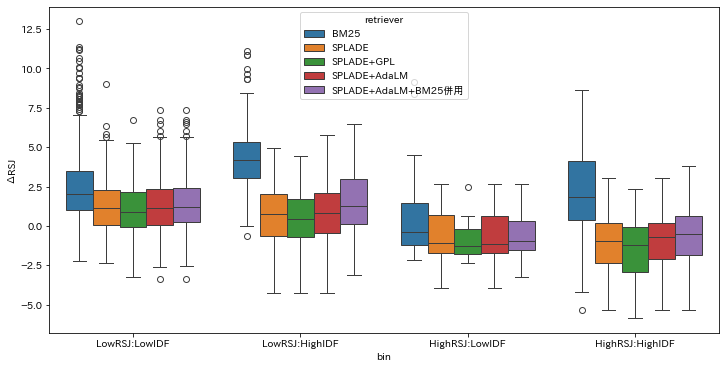

In [17]:
# bin_names = ["DF-:Under5", "DF+:Under5", "DF-:Over5", "DF+:Over5"]
# bin_names = ["LowIDF:Under5", "LowIDF:Under5", "HighIDF:Over5", "HighIDF:Over5"]
# bin_names = ["LowIDF", "HighIDF"]
# bin_names = ["LowIDF:LowRSJ", "LowIDF:LowRSJ", "HighIDF:HighRSJ", "HighIDF:HighRSJ"]
bin_names = ["LowRSJ:LowIDF", "LowRSJ:HighIDF", "HighRSJ:LowIDF", "HighRSJ:HighIDF"]
df_splade_rsj_info_bin = df_diff_rsj(comp_tk_name_and_path, rsj_u, bin_rsj_u, index_corpus, queries, N, bin_names)
fig, ax = plt.subplots(figsize=(12, 6))
# sns.set_style(style="whitegrid")
p = sns.boxplot(x='bin', y='ΔRSJ', hue="retriever", data=df_splade_rsj_info_bin, ax=ax)
p.set_title("NFCorpus", fontsize=20, fontproperties=fp)
p.set_xticklabels(bin_names, fontsize=16, fontproperties=fp)
p.set_yticklabels(p.get_yticks(), fontsize=16, fontproperties=fp)
# p.set_xlabel("$RSJ_{t, R_Q}$", fontsize=20, fontproperties=fp)
p.set_xlabel("", fontsize=20, fontproperties=fp)
p.set_ylabel("$\Delta RSJ_{t,Q}$", fontsize=20, fontproperties=fp)
plt.legend(fontsize='x-large')
fig = plt.figure()
fig = p.get_figure()
fig.savefig("fig3-2.svg", format="svg")

/tmp/ipykernel_2901649/1472813887.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(bin_names, fontsize=20)
/tmp/ipykernel_2901649/1472813887.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(p.get_yticks(), fontsize=16)


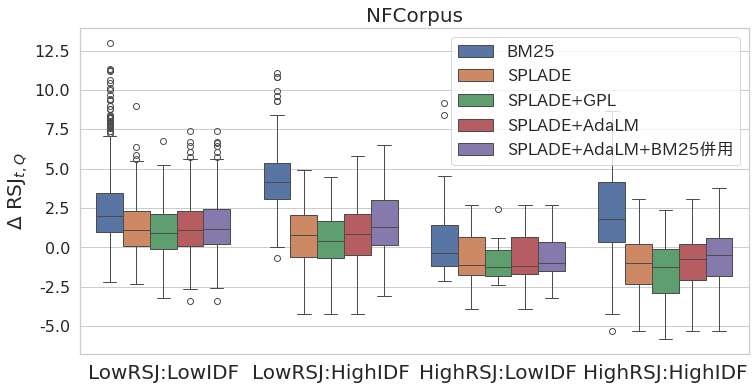

<Figure size 432x288 with 0 Axes>

In [20]:
# bin_names = ["DF-:Under5", "DF+:Under5", "DF-:Over5", "DF+:Over5"]
# bin_names = ["LowIDF:Under5", "LowIDF:Under5", "HighIDF:Over5", "HighIDF:Over5"]
# bin_names = ["LowIDF", "HighIDF"]
# bin_names = ["LowIDF:LowRSJ", "LowIDF:LowRSJ", "HighIDF:HighRSJ", "HighIDF:HighRSJ"]
bin_names = ["LowRSJ:LowIDF", "LowRSJ:HighIDF", "HighRSJ:LowIDF", "HighRSJ:HighIDF"]
df_splade_rsj_info_bin = df_diff_rsj(comp_tk_name_and_path, rsj_u, bin_rsj_u, index_corpus, queries, N, bin_names)
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_style(style="whitegrid")
sns.set(font='IPAexGothic', context='notebook', style="whitegrid")
p = sns.boxplot(x='bin', y='ΔRSJ', hue="retriever", data=df_splade_rsj_info_bin, ax=ax)
p.set_title("NFCorpus", fontsize=20)
p.set_xticklabels(bin_names, fontsize=20)
p.set_yticklabels(p.get_yticks(), fontsize=16)
# p.set_xlabel("$RSJ_{t, R_Q}$", fontsize=20)
p.set_xlabel("", fontsize=20)
p.set_ylabel("$\Delta$ RSJ$_{t,Q}$", fontsize=20)
plt.legend(fontsize='x-large')
fig = plt.figure()
fig = p.get_figure()
fig.savefig("fig3-2.svg", format="svg")

NameError: name 'fp' is not defined

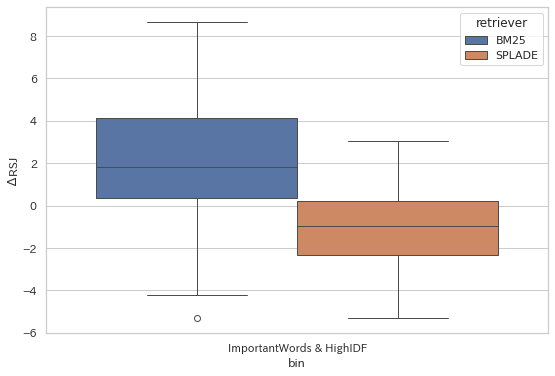

In [19]:
# bin_names = ["DF-:Under5", "DF+:Under5", "DF-:Over5", "DF+:Over5"]
# bin_names = ["LowIDF:Under5", "LowIDF:Under5", "HighIDF:Over5", "HighIDF:Over5"]
# bin_names = ["LowIDF", "HighIDF"]
# bin_names = ["LowIDF:LowRSJ", "LowIDF:LowRSJ", "HighIDF:HighRSJ", "HighIDF:HighRSJ"]
bin_names = ["LowRSJ:LowIDF", "LowRSJ:HighIDF", "HighRSJ:LowIDF", "HighRSJ:HighIDF"]
df_splade_rsj_info_bin = df_diff_rsj(for_intro_and_path, rsj_u, bin_rsj_u, index_corpus, queries, N, bin_names)
df_splade_rsj_info_bin = df_splade_rsj_info_bin[df_splade_rsj_info_bin["bin"] == "HighRSJ:HighIDF"]
df_splade_rsj_info_bin.replace("HighRSJ:HighIDF", "ImportantWords & HighIDF", inplace=True)
bin_names = ["ImportantWords & HighIDF"]
fig, ax = plt.subplots(figsize=(9, 6))
sns.set_style(style="whitegrid")
p = sns.boxplot(x='bin', y='ΔRSJ', hue="retriever", data=df_splade_rsj_info_bin, ax=ax)
# p.set_title("NFCorpus", fontsize=20, fontproperties=fp)
p.set_xticklabels(bin_names, fontsize=24, fontproperties=fp)
p.set_yticklabels(p.get_yticks(), fontsize=24, fontproperties=fp)
# p.set_xlabel("$RSJ_{t, R_Q}$", fontsize=20, fontproperties=fp)
p.set_xlabel("", fontsize=20, fontproperties=fp)
p.set_ylabel("Gap between ideal weight and \n model estimating weight", fontsize=28, fontproperties=fp)
plt.legend(fontsize='x-large')
fig = plt.figure()
fig = p.get_figure()
fig.savefig("fig-presen.svg", format="svg")

/tmp/ipykernel_1352881/1528536802.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(p.get_yticks(), fontsize=16, fontproperties=fp)


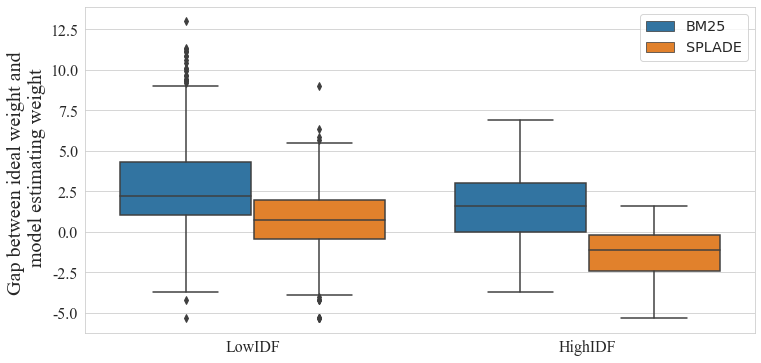

<Figure size 432x288 with 0 Axes>

In [62]:
# bin_names = ["DF-:Under5", "DF+:Under5", "DF-:Over5", "DF+:Over5"]
# bin_names = ["LowIDF:Under5", "LowIDF:Under5", "HighIDF:Over5", "HighIDF:Over5"]
bin_names = ["LowIDF", "HighIDF"]
# bin_names = ["LowIDF:LowRSJ", "LowIDF:LowRSJ", "HighIDF:HighRSJ", "HighIDF:HighRSJ"]
# bin_names = ["LowRSJ:LowIDF", "LowRSJ:HighIDF", "HighRSJ:LowIDF", "HighRSJ:HighIDF"]
df_splade_rsj_info_bin = df_diff_rsj(for_intro_and_path, rsj_u, bin_rsj_u_idf, index_corpus, queries, N, bin_names)
# df_splade_top_ranked_count = df_top_ranked_count(for_intro_and_path, bin_rsj_u_idf, index_corpus, queries, N, bin_names)
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_style(style="whitegrid")
p = sns.boxplot(x='bin', y='ΔRSJ', hue="retriever", data=df_splade_rsj_info_bin, ax=ax)
# p.set_title("NFCorpus", fontsize=20, fontproperties=fp)
p.set_xticklabels(bin_names, fontsize=16, fontproperties=fp)
p.set_yticklabels(p.get_yticks(), fontsize=16, fontproperties=fp)
# p.set_xlabel("$RSJ_{t, R_Q}$", fontsize=20, fontproperties=fp)
p.set_xlabel("", fontsize=20, fontproperties=fp)
p.set_ylabel("Gap between ideal weight and \n model estimating weight", fontsize=20, fontproperties=fp)
plt.legend(fontsize='x-large')
fig = plt.figure()
fig = p.get_figure()
fig.savefig("fig_presen.svg", format="svg")

/tmp/ipykernel_3743650/2017488400.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(p.get_yticks(), fontsize=24, fontproperties=fp)


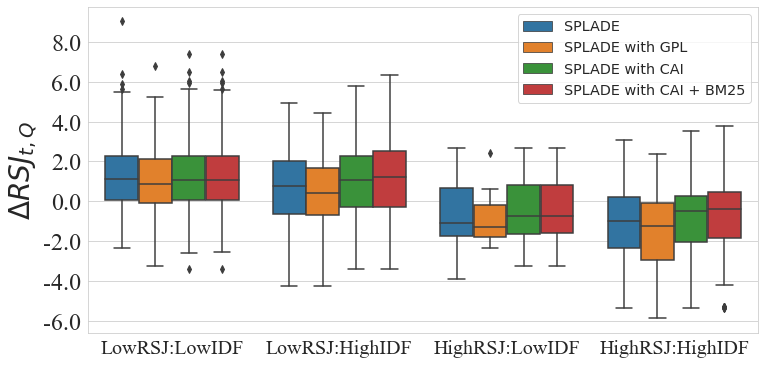

<Figure size 432x288 with 0 Axes>

In [20]:
# bin_names = ["DF-:Under5", "DF+:Under5", "DF-:Over5", "DF+:Over5"]
# bin_names = ["LowIDF:Under5", "LowIDF:Under5", "HighIDF:Over5", "HighIDF:Over5"]
# bin_names = ["LowIDF", "HighIDF"]
# bin_names = ["LowIDF:LowRSJ", "LowIDF:LowRSJ", "HighIDF:HighRSJ", "HighIDF:HighRSJ"]
bin_names = ["LowRSJ:LowIDF", "LowRSJ:HighIDF", "HighRSJ:LowIDF", "HighRSJ:HighIDF"]
df_splade_rsj_info_bin = df_diff_rsj(comp_tk_name_and_path, rsj_u, bin_rsj_u, index_corpus, queries, N, bin_names)
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_style(style="whitegrid")
p = sns.boxplot(x='bin', y='ΔRSJ', hue="retriever", data=df_splade_rsj_info_bin, ax=ax)
p.set_xticklabels(bin_names, fontsize=20, fontproperties=fp)
p.set_yticklabels(p.get_yticks(), fontsize=24, fontproperties=fp)
# p.set_xlabel("$RSJ_{t, R_Q}$", fontsize=20, fontproperties=fp)
p.set_xlabel("", fontsize=28, fontproperties=fp)
p.set_ylabel("$\Delta RSJ_{t,Q}$", fontsize=28, fontproperties=fp)
plt.legend(fontsize='x-large')
fig = plt.figure()
fig = p.get_figure()
fig.savefig("yans.svg", format="svg")

/tmp/ipykernel_330053/3515029374.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(p.get_yticks(), fontsize=16)


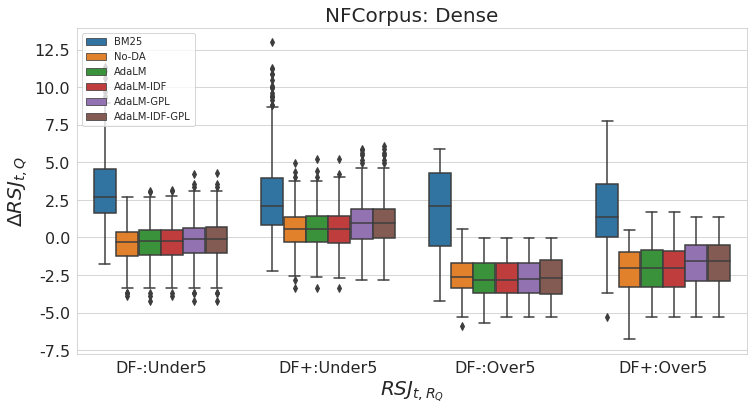

In [24]:
bin_names = ["DF-:Under5", "DF+:Under5", "DF-:Over5", "DF+:Over5"]
df_dense_rsj_info_bin = df_diff_rsj(dense_name_and_path, rsj_u, bin_rsj_u, index_corpus, queries, N, bin_names)
ig, ax = plt.subplots(figsize=(12, 6))
sns.set_style(style="whitegrid")
p = sns.boxplot(x='bin', y='ΔRSJ', hue="retriever", data=df_dense_rsj_info_bin, ax=ax)
p.set_title("NFCorpus: Dense", fontsize=20)
p.set_xticklabels(bin_names, fontsize=16)
p.set_yticklabels(p.get_yticks(), fontsize=16)
p.set_xlabel("$RSJ_{t, R_Q}$", fontsize=20)
p.set_ylabel("$\Delta RSJ_{t,Q}$", fontsize=20)
plt.legend(loc='upper left')